# Yelp Data Challenge - Topic Discovery Among Reviews
Restaurant owners would probably like to get a better understanding of diners, and data scientists can help by clustering (vectorizer) restaurant reviews. Here we utilize K-means clustering to discover
- the cuisines commonly reviewed in Las Vegas
- the concerns that diners commonly share

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('../data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


In [3]:
# Minor number of NAs in 'attributes'; fortunately, we won't need that feature
pd.DataFrame.sum(df.isna())

business_id     0
name            0
categories      0
avg_stars       0
attributes     84
cool            0
date            0
funny           0
review_id       0
stars           0
text            0
useful          0
user_id         0
dtype: int64

In [4]:
# Take the values of the column that contains review text data, save to a variable named "documents"
documents = df.text

In [5]:
# The number of reviews
print(documents.shape)

(101569,)


## Data-driven discovery of stop words
For this exercise we will consider unigrams and bigrams only. We will plot their frequency distribution, and experiment with various cutoffs for rejecting tokens. In particular, we want to filter out words that are
1. so common that they contain little specific information
2. so infrequent that they describe specific niche situations.

To accomplish the goals above, two successive steps are taken:
1. Filter tokens with too small/big a document-frequency.
2. Then, count the remaining tokens, and determine additional thresholds on *corpus-wide* term frequencies

In [6]:
from nltk.corpus import stopwords
import re

def scrub_symbols(text):
    # Remove all punctuation to facilitate filtering out stop words
    # Replace by space instead of empty string, so that words don't accidentally stick together
    scrubbed_text = re.sub(r"[(<.*?>,!)]", " ", text)
    return scrubbed_text

def filter_grammatical_sw(review, stop_words):
    '''
        Filter out grammatical stop words (unigrams) from a review. 
        Take lower case automatically, since stop words list (likely) all lower-case
        
        Args:
            review: a string containing a restaurant review
            stop_words: set containing stop words (strs)
        Returns:
            filtered_review: string, with all specified stop words removed
    '''
    
    filtered_review = ' '.join([word for word in scrub_symbols(review.lower()).split() 
                                if word not in stop_words])
    return filtered_review

In [7]:
grammatical_sw = stopwords.words('english')
grammatical_sw.remove('not') #Important sentiment information!
grammatical_sw.remove('no') #Important sentiment information!

documents_filtered = documents.apply(filter_grammatical_sw, args=(grammatical_sw,))

In [8]:
print(sorted(grammatical_sw))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't',

In [9]:
print_these = (101, 23, 6)
for index in print_these:
    print('* ORIGINAL * ', documents[index], '\n', '* FILTERED * ', documents_filtered[index], '\n')

* ORIGINAL *  This was one of the best one out here I from San Diego and I can't call the food was like if my grandma just made it the waiter was great 
 * FILTERED *  one best one san diego can't call food like grandma made waiter great 

* ORIGINAL *  Unfortunately there's no option for zero stars, today the customer in front of me walk away because the extra charge and lack of customer service of the Asian female manager, I asked for 8 piece chicken and I asked all thighs and she wanted me to charge 1.79 on top of the 9.99 for each one! 
 * FILTERED *  unfortunately there's no option zero stars today customer front walk away extra charge lack customer service asian female manager asked 8 piece chicken asked thighs wanted charge 1 79 top 9 99 one 

* ORIGINAL *  What a place . They never answer the phone. Went to get pizza and the internet did not let me put the code in for taking the survey. Counter girl said she would let me slide. This place is a joke . Will find another place to 

Now that grammatical stop words are dealt with, let's try to find topic-specific ones.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
# First filter by DF: note the arguments fed into CountVectorizer
# To reiterate: we have ~100,000 reviews. 1% of that is 1000 reviews, reasonable min_df?
# No point going beyond bigrams, when word connectivity is destroyed by filtering grammatical stop words

count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.95)
token_counts = count_vectorizer.fit_transform(documents_filtered)

In [12]:
# Turn into numpy arrays for boolean masking later
unigram_indices = np.asarray([ix for token,ix in count_vectorizer.vocabulary_.items() \
                              if len(token.split())==1])

bigram_indices = np.asarray([ix for token,ix in count_vectorizer.vocabulary_.items()\
                             if len(token.split())==2])

In [13]:
# CORPUS-WIDE term frequency; take log10 to compress the range
unigram_tf = np.log10( np.sum(token_counts[:, unigram_indices], axis=0) )
bigram_tf = np.log10( np.sum(token_counts[:, bigram_indices], axis=0) )

# Without these two lines, plotting cumulative frequencies would take forever
unigram_tf = np.asarray(unigram_tf).reshape(-1)
bigram_tf = np.asarray(bigram_tf).reshape(-1)

Text(0.5, 1.0, 'Bigram Distribution')

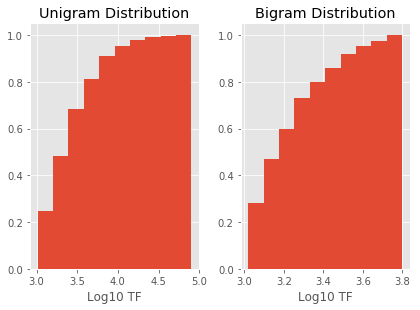

In [14]:
# Cumulative frequency plot of corpus-wide TF
# Rather arbitarily, we will remove tokens beyond 0.9; will validate results manually below

fig, axes = plt.subplots(1,2)
plt.tight_layout()
axes[0].hist(unigram_tf, bins=10, cumulative=True, density=True)
axes[1].hist(bigram_tf, bins=10, cumulative=True, density=True)

axes[0].set_xlabel("Log10 TF")
axes[1].set_xlabel("Log10 TF")

axes[0].set_title("Unigram Distribution")
axes[1].set_title("Bigram Distribution")

### Filter and validate!

In [15]:
# Create index-to-string lookup table; so that we know which tokens are filtered out
ix_to_token = {ix:token for token,ix in count_vectorizer.vocabulary_.items()}

In [29]:
# Thresholds of 4.x and ~3.x eyeballed from cumulative frequency graphs
# Tried a few near values to optimize results --- e.g. so that no tokens describing
# specific food items are included in the 'drop list'

# Earlier in the pipleine we have attempted to remove common, grammatical stop words
# As seen below, that effort was largely successful, with only a few exceptions such as 'would', 'also'...
# In particular, 'no' and 'not' as unigrams don't contain much info, and so we will get rid of them.

# There are also culinary-themed themes that are presumably common in reviews of Las 
# Vegan restaurants --- e.g. 'restaurant', 'vegas', 'las vegas'. 
# As such, they will be treated as stop words.

unigrams_to_drop_ix = unigram_indices[unigram_tf > 4.25]
bigrams_to_drop_ix = bigram_indices[bigram_tf > 3.7]

excess_unigrams = set([ix_to_token[ix] for ix in unigrams_to_drop_ix])
excess_bigrams = set([ix_to_token[ix] for ix in bigrams_to_drop_ix])

print(excess_unigrams)
print(excess_bigrams)

{'back', 'best', 'also', 'great', 'got', 'came', 'one', 'really', 'restaurant', 'service', 'order', 'like', 'would', 'go', 'ordered', 'us', 'chicken', 'vegas', 'food', 'not', 'get', 'time', 'good', 'delicious', 'place', 'no'}
{'come back', 'customer service', 'las vegas'}


In [30]:
# Inspected print out above, and manually decided to retain any potentially informative tokens
fudge_sw_unigram = ['chicken', 'service', 'time', 'delicious']
for tok in fudge_sw_unigram:
    excess_unigrams.remove(tok)

fudge_sw_bigram = ['customer service']
for tok in fudge_sw_bigram:
    excess_bigrams.remove(tok)

Form Python list containing final vocab!

In [31]:
final_vocab = [token for token in count_vectorizer.vocabulary_.keys() 
               if (token not in excess_bigrams) and (token not in excess_unigrams)]
# print(sorted(final_vocab))

## Obtain TF-IDF representation of `documents`

Consider only unigrams + bigrams, and obtain Tf-Idf vectors of `documents`. 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# Create TfidfVectorizer, and name it vectorizer
# Since vocabulary is already given, no need to specifcy ngram range etc
tfidf_vectorizer = TfidfVectorizer(vocabulary=final_vocab)

In [33]:
# Fit the vectorizer with all available data
vec_doc = tfidf_vectorizer.fit_transform(documents_filtered)

In [34]:
# Now that vectorizer is fitted, Get the vocab of your tfidf
# vectorizer.vocabulary_ records feature indices!
token_to_index = tfidf_vectorizer.vocabulary_

# Reverse dictionary for interpreting results
index_to_token = {index:token for token,index in token_to_index.items()}

print("Vocabulary contains {} items".format(len(tfidf_vectorizer.vocabulary_)))

Vocabulary contains 847 items


## Finally, cluster reviews with KMeans
Fit k-means clustering with "training data", and then apply it on the entire data set. Tune with the elbow method.

In [35]:
# Using sklearn.cluster.MiniBatchKMeans instead of sklearn.cluster.KMeans
# Slightly worse clustering maybe? But much faster convergence

from sklearn.cluster import MiniBatchKMeans

In [36]:
# Define function for printing top features of each cluster
# 'Top features' being the largest components of the centroid vector 
# Remember: TF-IDF vector components are always non-negative, so we don't have to worry about sign

def print_top_features(kmeans_obj, ix_to_tokens, n=10):
    '''
        Reveals the 'most important' tokens in each KMeans cluster
        
        Args:
            kmeans_obj: fitted sklearn.cluster.MiniBatchKMeans() or KMeans() object
            ix_to_tokens: dictionary mapping feature indices to string token
            n: integer number of top tokens to display
    '''
    cluster_centers = kmeans_obj.cluster_centers_
    labels = kmeans_obj.labels_
    
    for i, centroid in enumerate(cluster_centers):
        top_n_features = np.argsort(centroid)[::-1]
        top_n_features = top_n_features[:n]
        top_n_words = [ix_to_tokens[feature_index] for feature_index in top_n_features]

        print("Top tokens from cluster {} (# of obs: {})".format(i, (labels==i).sum()))
        print(top_n_words)

In [37]:
# Start with arbitrary K = 3, as a trial
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=500, max_iter=1000, n_init=5)
kmeans.fit(vec_doc)
print_top_features(kmeans, index_to_token, n=10)

Top tokens from cluster 0 (# of obs: 50745)
['service', 'chicken', 'amazing', 'love', 'nice', 'time', 'definitely', 'always', 'sushi', 'try']
Top tokens from cluster 1 (# of obs: 33373)
['pizza', 'time', 'service', 'even', 'never', 'minutes', 'come', 'bad', 'people', 'location']
Top tokens from cluster 2 (# of obs: 17451)
['delicious', 'friendly', 'staff', 'breakfast', 'service', 'definitely', 'fresh', 'lunch', 'amazing', 'time']


### Experiment with different K

Attempt to find optimal K's using elbow method. Also tried silhouette score, but computations on a representative sample takes far too long. Elbow method it is!

In [26]:
from Elbow import elbow_tuner

Text(0, 0.5, 'Mean Intra-cluster SS')

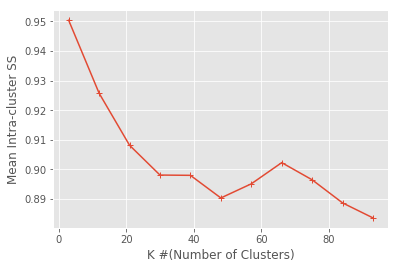

In [27]:
k_to_try = range(3, 100, 9)

# intra_cluster_ss = elbow.elbow_tuner(vec_doc, k_to_try)
intra_cluster_ss = elbow_tuner(vec_doc, k_to_try)

plt.plot(k_to_try, intra_cluster_ss, '-+')
plt.xlabel('K #(Number of Clusters)')
plt.ylabel('Mean Intra-cluster SS')

In [38]:
'''
    Take first elbow at around K=25; tried values larger than 25, 
    but that gives multiple clusters that contain only one obseration.
    Finally, print top features related to each cluster
'''

kmeans_final = MiniBatchKMeans(n_clusters=25).fit(vec_doc)
print_top_features(kmeans_final, index_to_token, n=8)

Top tokens from cluster 0 (# of obs: 3538)
['excellent', 'service', 'highly', 'recommend', 'amazing', 'delicious', 'definitely', 'friendly']
Top tokens from cluster 1 (# of obs: 5275)
['chicken', 'fried', 'rice', 'salad', 'sauce', 'delicious', 'service', 'try']
Top tokens from cluster 2 (# of obs: 2055)
['visit', 'time', 'service', 'first', 'definitely', 'next', 'amazing', 'every']
Top tokens from cluster 3 (# of obs: 3444)
['wait', 'long', 'can', 'time', 'minutes', 'service', 'staff', 'come']
Top tokens from cluster 4 (# of obs: 3071)
['sushi', 'roll', 'rolls', 'burrito', 'fresh', 'service', 'eat', 'definitely']
Top tokens from cluster 5 (# of obs: 2526)
['buffet', 'price', 'crab', 'selection', 'station', 'quality', 'dinner', 'seafood']
Top tokens from cluster 6 (# of obs: 1)
['awesome', 'cute', 'visiting', 'soon', 'thank', 'they', 'rolls', 'free']
Top tokens from cluster 7 (# of obs: 15568)
['service', 'time', 'even', 'never', 'said', 'minutes', 'asked', 'table']
Top tokens from clus

## Summary and Observations

### Popular Categories of Food
(Vietnamese) pho noodles, (Japanese) ramen, sushi, pizzas, Thai curry, fried rice, buffet, seafood...all have their place in Las Vegas. Contrary to an earlier clustering attempt, it is not immediately obvious which types of food are more popular. This variation in results across clustering attempts reminds us that K-means clustering, as a random algorithm, can only provide a rough overview of the data.

### Items of Attention for Restaurants
In case it isn't crystal clear, the **taste** of food matters --- as shown by the recurrence of 'delicious' in eight different clusters. It is also vital to have **friendly staff** and **good service**. Remember that 'service' and 'delicious' almost became stop words by their sheer frequency counts!

On the other hand, as shown in `Preprocessing.ipynb`, most reviews gave 3 stars or above. Therefore it is no wonder that tokens presenting positive sentiments e.g. 'delicious' are overwhelmingly represented, while we hardly see negative ones. To put culinary pitfalls into focus, we must analyze  bad reviews separately.

### Further Refinement of Analysis Technique?
By removing grammatical stop words at the very beginning, it seems we have avoided having repetitive tokens --- which plagued the previous iteration of this notebook. That's encouraging!

To put interesting information more sharpyl into focus, we can try a, instead of extracting n-grams in a straightforward, brute-force manner. This [blog post by Git(Hub) data scientist Kavita Ganesan](http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.WuiiKtMvyds) may contain some clues, but in the interest of time I will stop here for now.

A more esoteric concern is that clustering results may be quantitatively mediocre. Since scikit-learn's TfidfVectorizer normalizes the L2 norm of each observation to unit length, a RMS distance of 0.9x between observations and their cluster centroids implies that observations are spread out sparely in the 'TF-IDF hypersphere'.

Could this a manifestation of the dimensionality curse? We do have hundreds features after all. Maybe we can apply PCA first, then cluster and attempt to discover themes? Will leave this for the next iteration of notebook.